In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import train_test_split

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [ ]:
# code to connect to drive to access data
from google.colab import drive
drive.mount('/content/drive')

#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Loading
This dataset contains a lot of variables, including a few variations of the target variable, above average low literacy levels in people with at least a bachelors degree. It is a modified version of a dataset from https://nces.ed.gov/surveys/piaac/skillsmap/, which ordinarily contains 43 variables. I moved the Level one literacy (reading difficulties) and Mathematicals difficulties  proportions for people with at least a bachelors degree to a seperate column so it could be matched with the data for entire county populations. I also created two bivariate variables, Cat_Lit1 and Cat_Num1, which are categorical variables that indicate whether the former variables are above the median. Combo_cat was supposed to be a variable that showed 0 if both were zero and the counties degree holders were below the median, 1 if only Cat_lit1 was 1, 2 if only Cat_Num1 was 1, and 3 if both were 1, but every county that had an above median rate of bachelor degree holders with literacy issues also had an above median rate of bachelor degree holders with numeracy issues, so all three variables essentially have a perfect correlation. Since these label variables are included in the main dataset, there is only one dataset to load.

In [ ]:

Start_Data = pd.read_csv('drive/MyDrive//UML_FinDat.csv')




EDA

In [ ]:
# number of observations and features
print(Start_Data.shape)

#StartData = StartData[:,:-1]
#values for label data
#print(label.shape)
#display of part of dataframe
Start_Data.info()
Start_Data[1:5]

(3142, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FIPS_code       3142 non-null   int64  
 1   State           3142 non-null   object 
 2   County          3142 non-null   object 
 3   grpName         3142 non-null   object 
 4   Lit_P1          3142 non-null   float64
 5   Lit_P2          3142 non-null   float64
 6   Lit_P3          3142 non-null   float64
 7   Lit_A           3142 non-null   float64
 8   Num_P1          3142 non-null   float64
 9   Num_P2          3142 non-null   float64
 10  Num_P3          3142 non-null   float64
 11  Num_A           3142 non-null   float64
 12  POP             3142 non-null   int64  
 13  POP_Mature      3141 non-null   float64
 14  Male            3142 non-null   float64
 15  Female          3142 non-null   float64
 16  White           3142 non-null   float64
 17  Black           3142 n

,FIPS_code,State,County,grpName,Lit_P1,Lit_P2,Lit_P3,Lit_A,Num_P1,Num_P2,...,OCC_Sales,OCC_Natural,OCC_Military,OCC_Prod,No_Insurance,Lit1_Bachelors,Num1_Bachelors,Cat_Lit1,Cat_Num1,Combo_cat
1,1003,Alabama,Baldwin County,all,0.161,0.347,0.493,270.3,0.261,0.353,...,0.257,0.096,0.0,0.106,0.108,0.025,0.041,0,0,0
2,1005,Alabama,Barbour County,all,0.394,0.404,0.201,235.9,0.581,0.273,...,0.225,0.114,0.0,0.239,0.123,0.062,0.092,1,1,3
3,1007,Alabama,Bibb County,all,0.269,0.454,0.277,248.1,0.417,0.402,...,0.196,0.153,0.0,0.228,0.081,0.042,0.066,0,0,0
4,1009,Alabama,Blount County,all,0.248,0.370,0.382,258.5,0.352,0.341,...,0.233,0.158,0.0,0.193,0.110,0.039,0.056,0,0,0


In [ ]:
#create label dataset and remove variables from main data
#main label investigaton
print("here",Start_Data['Cat_Lit1'].quantile(0.75))
main_label = Start_Data[['Cat_Lit1']].copy()
main_label = main_label.rename(columns={'Cat_Lit1':'label'})
main_label["label"] = main_label["label"].replace("lower", 0)
main_label["label"] = main_label["label"].replace("higher", 1)
# create a different label for higher reading difficulties per capita with a cutoff other than the median, 0.045.
label_adj_L = Start_Data.assign(label = Start_Data['Lit1_Bachelors'] >= 0.08)
label_adj_L = pd.DataFrame(label_adj_L.iloc[:,-1])
# create a different label for higher mathematics difficulties per capita with a cutoff other than the median, 0.079.
label_adj_N = Start_Data.assign(label = Start_Data['Lit1_Bachelors'] >= 0.079)
label_adj_N = pd.DataFrame(label_adj_L.iloc[:,-1])

#remove label data from initial dataset
#Start_Data = Start_Data.iloc[:,:-5]
#label_adj_N.info()

main_label = main_label
main_label.sum()

here 1.0


label    1537
dtype: int64

In [ ]:
#create 4 part categorical variable


# Calculate percentiles using numpy.percentile
percentiles = [25,5,75]
percentile_values = np.percentile(Start_Data['Lit1_Bachelors'], percentiles)
print(percentile_values)
#change variable
StartData['label_adj_L'] = pd.cut(x=Start_Data['Lit1_Bachelors'], bins=[0, 0.034, 0.045, 0.06, 1],
                     labels=['Best', 'Better', 'Worse',
                             'Worst'])
main_label4 = StartData[['label_adj_L']].copy()
main_label4 = main_label4.rename(columns={'label_adj_L':'label'})

[0.034 0.023 0.06 ]


Data visualizations.

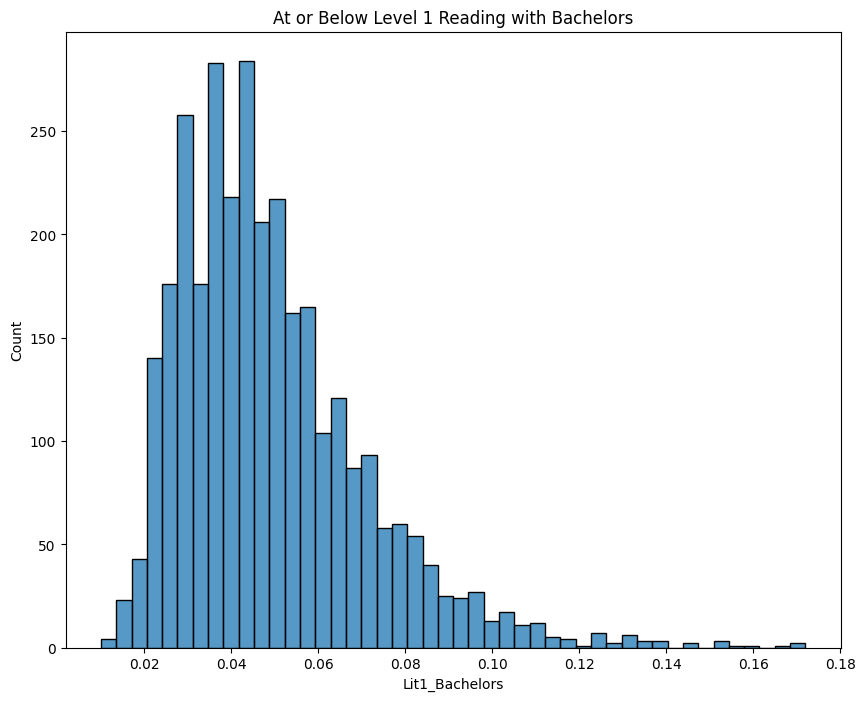

In [ ]:
# label data first
#Histogram of proportion of bachelor holders with  reading defificency
plt.figure(figsize=(10, 8))
sns.histplot(Start_Data, x = 'Lit1_Bachelors')
plt.title('At or Below Level 1 Reading with Bachelors')
plt.show()
#The histogram shows a strong positive skew

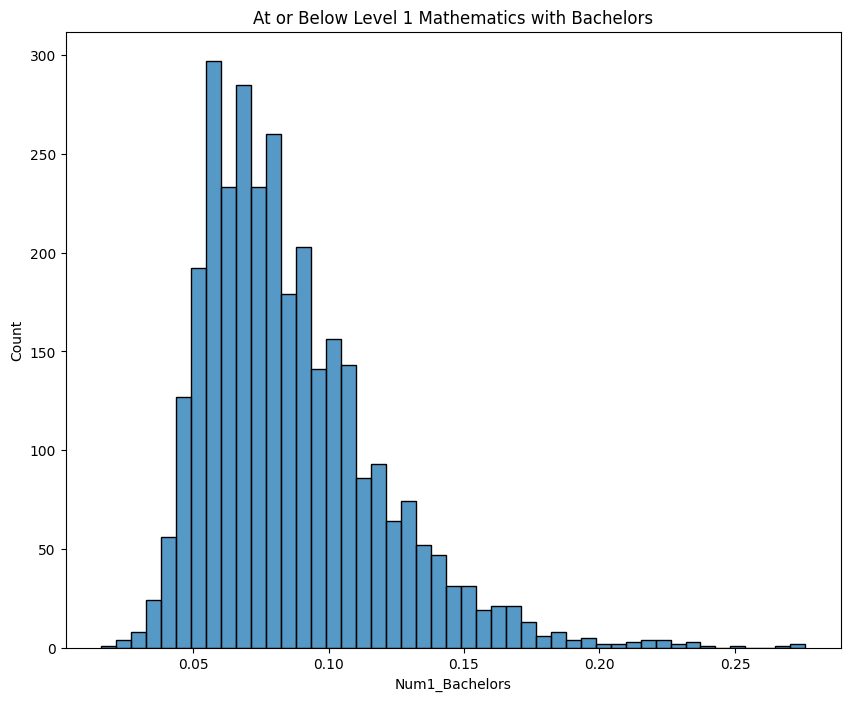

In [ ]:
#Histogram of proportion of bachelor holders with mathematics defificency
plt.figure(figsize=(10, 8))
sns.histplot(Start_Data, x = 'Num1_Bachelors')
plt.title('At or Below Level 1 Mathematics with Bachelors')
plt.show()
#The histogram also shows a strong positive skew

In [ ]:
# much of the data is in proportions while some is in population totals
# I separate out the proportion data for some descriptive statistics
Data_prop1 = Start_Data.iloc[:,4:7].copy()
Data_prop2 = Start_Data.iloc[:,8:11].copy()
Data_prop3 = Start_Data.iloc[:,14:43].copy()
Data_propf = pd.concat([Data_prop1, Data_prop2, Data_prop3], axis=1)
Data_propf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lit_P1         3142 non-null   float64
 1   Lit_P2         3142 non-null   float64
 2   Lit_P3         3142 non-null   float64
 3   Num_P1         3142 non-null   float64
 4   Num_P2         3142 non-null   float64
 5   Num_P3         3142 non-null   float64
 6   Male           3142 non-null   float64
 7   Female         3142 non-null   float64
 8   White          3142 non-null   float64
 9   Black          3142 non-null   float64
 10  Hispanic       3142 non-null   float64
 11  Asian          3142 non-null   float64
 12  AIAN           3142 non-null   float64
 13  NHPI           3142 non-null   float64
 14  Other_race     3142 non-null   float64
 15  Less_HS        3142 non-null   float64
 16  HS             3142 non-null   float64
 17  More_HS        3142 non-null   float64
 18  Eng_not_

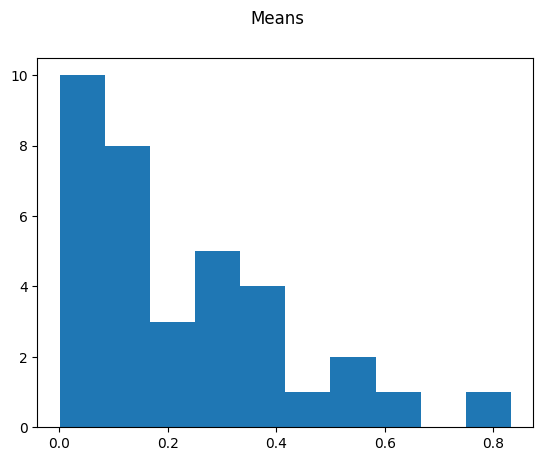

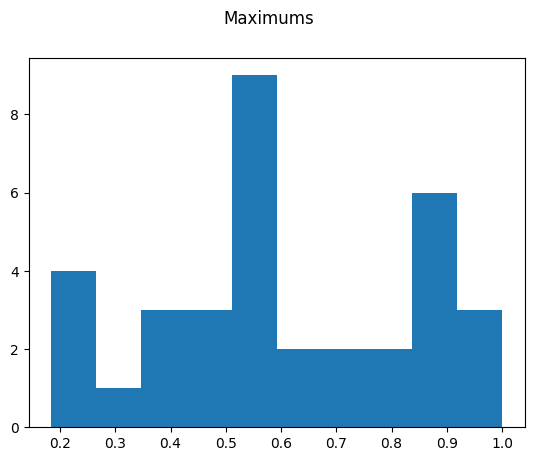

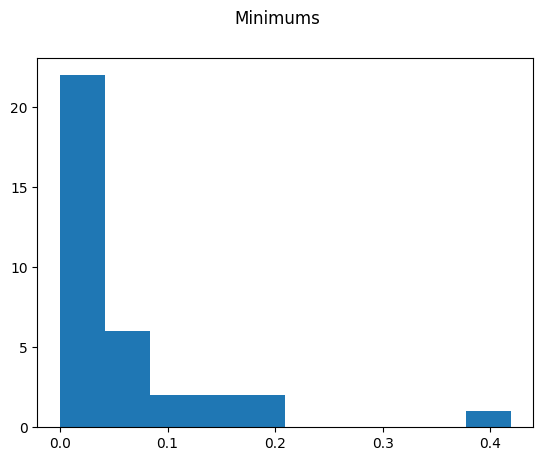

In [ ]:
#histograms of mean, max and min values for proportions
a = Data_propf.mean(axis=0)
plt.hist(a)
plt.suptitle("Means")
plt.show()
b = Data_propf.max(axis=0)
plt.hist(b)
plt.suptitle("Maximums")
plt.show()
c = Data_propf.min(axis=0)
plt.hist(c)
plt.suptitle("Minimums")
plt.show()

In [ ]:
#filter data to remove extraneous variables
#remove label data from initial dataset and categorial location variables with nrow categories.
Fin_Data = Start_Data.iloc[:,4:-5]
Fin_Data.dropna()
Fin_Data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lit_P1         3142 non-null   float64
 1   Lit_P2         3142 non-null   float64
 2   Lit_P3         3142 non-null   float64
 3   Lit_A          3142 non-null   float64
 4   Num_P1         3142 non-null   float64
 5   Num_P2         3142 non-null   float64
 6   Num_P3         3142 non-null   float64
 7   Num_A          3142 non-null   float64
 8   POP            3142 non-null   int64  
 9   POP_Mature     3141 non-null   float64
 10  Male           3142 non-null   float64
 11  Female         3142 non-null   float64
 12  White          3142 non-null   float64
 13  Black          3142 non-null   float64
 14  Hispanic       3142 non-null   float64
 15  Asian          3142 non-null   float64
 16  AIAN           3142 non-null   float64
 17  NHPI           3142 non-null   float64
 18  Other_ra

<Axes: >

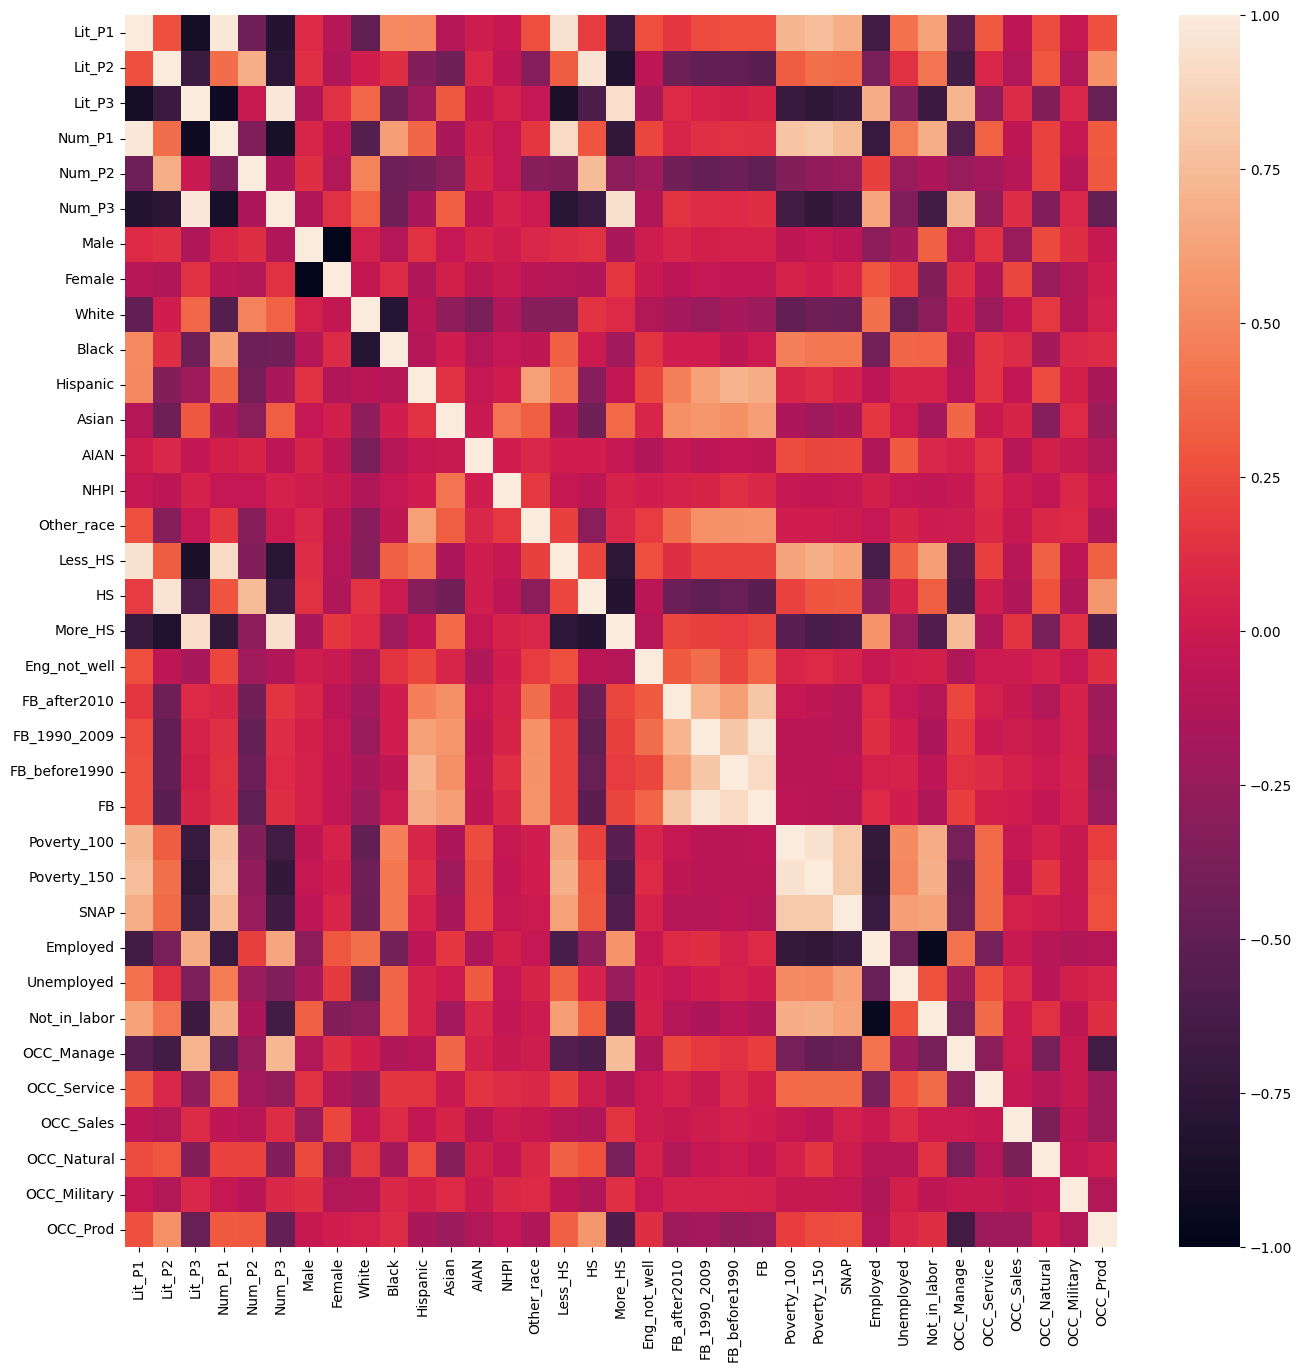

In [ ]:
# proportion data heatmap
Data_propf.corr()
corr = Data_propf.corr()
#size heatmap
plt.figure(figsize=(16,16))
# plot the heatmap
sns.heatmap(corr)

The heatmap shows that low literacy rates are correlated with being outside the labor force or unemployed, being in poverty, using SNAP, having less than a high school education, and inumeracy in the same county, which does not match the typical variables that correlated with More_HS, those who graduated high school and attended at least some post secondary education.

In [ ]:
# build a model using n_clusters
# there isn't a specific number of clusters that should be imposed on the data but the earlier labels for dividing the data are a potential starting point.
model=None
# your code here
cluster = AgglomerativeClustering(n_clusters=2)
model2 = cluster.fit(Data_propf)
model2
print(model2.labels_)

[1 1 0 ... 1 1 1]


In [ ]:
def label_permute_compare2(ytdf,yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
# your code here
    #make list of combinations
    intial_list = [*range(0,n, 1)]
    list_permutations = list(itertools.permutations(intial_list))
    #set up intial values for iteration
    most_acc = list_permutations[0]
    acc = 0.0
    newdf = []
    #iterate accross all permutations
    for i in list_permutations:
        newdf = ytdf.copy()
        newdf["label"] = newdf["label"].replace("lower", i[0])
        newdf["label"] = newdf["label"].replace("higher", i[1])
        score = accuracy_score(newdf["label"], yp)
        if score > acc:
            most_acc = i
            acc = score

    return most_acc, acc

In [ ]:
labelorder2, acc2 = label_permute_compare2(main_label, model2.labels_)
print(main_label.sum())
print(labelorder2, acc2)

label    1537
dtype: int64
(0, 1) 0.1954169318905156


In [ ]:
# programmatically evaluate which linkage method and distance metric lead to the best performance
# for two clusters
distance_metrics = ["euclidean", "l1", "l2", "manhattan", "cosine" ]#,"precomputed"]
linkage_methods = ["complete", "average", "single"]
best_distance_metric = "None"
best_linkage_method = "None"
best_labels = (0, 0)
highest_accuracy = 0.0
best_model = []
for i in distance_metrics:
    for j in linkage_methods:
        cluster_new2 = AgglomerativeClustering(n_clusters=2, metric = i, linkage=j)
        model_new2 = cluster_new2.fit(Data_propf)
        labelorder2, acc2 = label_permute_compare2(main_label, model_new2.labels_)
        if acc2 > highest_accuracy:
            best_distance_metric = i
            best_linkage_method = j
            best_labels = labelorder2
            highest_accuracy = acc2
            best_model = model_new2
print(best_distance_metric,best_linkage_method)
print(best_labels, highest_accuracy)
print("Confusion Matrix")
newdf2 = main_label.copy()
newdf2["label"] = newdf2["label"].replace("lower", best_labels[0])
newdf2["label"] = newdf2["label"].replace("higher", best_labels[1])
main_con_matrix = confusion_matrix(newdf2,best_model.labels_)


euclidean average
(0, 1) 0.5264162953532782
Confusion Matrix


## Now 4 part categorical variable

In [ ]:
# build a model using n_clusters=4 option
model4=None
# your code here
cluster4 = AgglomerativeClustering(n_clusters=4)
model4 = cluster4.fit(Data_propf)
model4
print(model4.labels_)

[0 0 2 ... 0 0 0]


In [ ]:
def label_permute_compare4(ytdf,yp,n=4):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
# your code here
    #make list of combinations
    intial_list = [*range(0,n, 1)]
    list_permutations = list(itertools.permutations(intial_list))
    #set up intial values for iteration
    most_acc = list_permutations[0]
    acc = 0.0
    newdf = []
    #iterate accross all permutations
    for i in list_permutations:
        newdf = ytdf.copy()
        newdf["label"] = newdf["label"].replace("Best", i[0])
        newdf["label"] = newdf["label"].replace("Better", i[1])
        newdf["label"] = newdf["label"].replace("Worse", i[2])
        newdf["label"] = newdf["label"].replace("Worst", i[3])
        score = accuracy_score(newdf["label"], yp)
        if score > acc:
            most_acc = i
            acc = score

    return most_acc, acc
        #print(ytdf)

In [ ]:
labelorder, acc = label_permute_compare4(main_label4, model4.labels_)
print(labelorder, acc)

(0, 1, 3, 2) 0.45544239338001274


In [ ]:
# programmatically evaluate which linkage method and distance metric lead to the best performance
# your code here
distance_metrics = ["euclidean", "l1", "l2", "manhattan", "cosine"]
linkage_methods = ["complete", "average", "single"]
best_distance_metric = "None"
best_linkage_method = "None"
best_labels = (0, 0, 0, 0)
highest_accuracy = 0.0
best_model = []
for i in distance_metrics:
    for j in linkage_methods:
        cluster_new = AgglomerativeClustering(n_clusters=4, metric = i, linkage=j)
        model_new4 = cluster_new.fit(Data_propf)
        labelorder4, acc4 = label_permute_compare4(main_label4, model_new4.labels_)
        if acc2 > highest_accuracy:
            best_distance_metric = i
            best_linkage_method = j
            best_labels = labelorder4
            highest_accuracy = acc4
            best_model = model_new4
print(best_distance_metric,best_linkage_method)
print(best_labels, highest_accuracy)
print("Confusion Matrix")
newdf2 = main_label4.copy()
newdf2["label"] = newdf2["label"].replace("Best", best_labels[0])
newdf2["label"] = newdf2["label"].replace("Better", best_labels[1])
newdf2["label"] = newdf2["label"].replace("Worse", best_labels[2])
newdf2["label"] = newdf2["label"].replace("Worst", best_labels[3])
confusion_matrix(newdf2,best_model.labels_)

cosine single
(0, 1, 2, 3) 0.26161680458306813
Confusion Matrix


array([[820,   0,   0,   0],
       [784,   0,   1,   0],
       [784,   0,   1,   0],
       [750,   1,   0,   1]])

## 3 Group Model, Tails and Center

In [ ]:
#create 2 part categorical variable


# Calculate percentiles using numpy.percentile
percentiles = [50,80]
percentile_values = np.percentile(Start_Data['Lit1_Bachelors'], percentiles)
print(percentile_values)
#change variable
StartData['label_adj_L'] = pd.cut(x=Start_Data['Lit1_Bachelors'], bins=[0, 0.05, 0.085, 1],
                     labels=['Tail1', 'Central', 'Tail2'])
main_label_TC = StartData[['label_adj_L']].copy()
main_label_TC = main_label_TC.rename(columns={'label_adj_L':'label'})

model3=None
# your code here
cluster3 = AgglomerativeClustering(n_clusters=3)
model3 = cluster3.fit(Data_propf)
model3
print(model3.labels_)
def label_permute_compare3(ytdf,yp,n=3):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
# your code here
    #make list of combinations
    intial_list = [*range(0,n, 1)]
    list_permutations = list(itertools.permutations(intial_list))
    #set up intial values for iteration
    most_acc = list_permutations[0]
    acc = 0.0
    newdf = []
    #iterate accross all permutations
    for i in list_permutations:
        newdf = ytdf.copy()
        newdf["label"] = newdf["label"].replace("Tail1", i[0])
        newdf["label"] = newdf["label"].replace("Central", i[1])
        newdf["label"] = newdf["label"].replace("Tail2", i[2])
        score = accuracy_score(newdf["label"], yp)
        if score > acc:
            most_acc = i
            acc = score

    return most_acc, acc , newdf
labelorder3, acc3, cdf = label_permute_compare3(main_label_TC, model3.labels_)
print(main_label.sum())
print(labelorder3, acc3)
confusion_matrix(cdf,model3.labels_)

[0.045 0.064]
[1 1 2 ... 1 1 1]
label    1537
dtype: int64
(1, 0, 2) 0.6467218332272437


array([[ 113,    5,   67],
       [ 472,  217,  339],
       [ 311, 1493,  125]])

##K-Means Clustering

In [ ]:

# time kmeans to compare to hierarchical clustering

ts_ac1 = time.time()
cluster = AgglomerativeClustering(n_clusters=2)
acmodel = cluster.fit(Data_propf)
ts_ac2 = time.time()
print("Agglomerative Clustering Time")
print(ts_ac2-ts_ac1)
print("Agglomerative Clustering Model Accuracy")
print(acc)
print("Agglomerative Clustering Confusion Matrix")
print(main_con_matrix)
ts_km1 = time.time()
kmean = KMeans(n_clusters=2)
kmmodel = kmean.fit(Data_propf)
ts_km2 = time.time()
print("K-Means Clustering Time")
print(ts_km2-ts_km1)
kmlabelorder, kmacc = label_permute_compare2(main_label, kmmodel.labels_)
print("Kmeans Clustering Model Accuracy")
print(kmacc)
newdf3 = main_label.copy()
newdf3["label"] = newdf3["label"].replace("Better", kmlabelorder[0])
newdf3["label"] = newdf3["label"].replace("Worse", kmlabelorder[1])
print("Kmeans Clustering Confusion Matrix")
kmconf = confusion_matrix(newdf3,kmmodel.labels_)
print(kmconf)

Agglomerative Clustering Time
0.42246317863464355
Agglomerative Clustering Model Accuracy
0.45544239338001274
Agglomerative Clustering Confusion Matrix
[[1605    0]
 [1488   49]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Clustering Time
0.7115132808685303
Kmeans Clustering Model Accuracy
0.8010821133036282
Kmeans Clustering Confusion Matrix
[[1531   74]
 [ 551  986]]


## Conclusion
None of the Hierachial methods were very accurate, about as good as chance and often worse. They were unable to outperform K-Means clustering in any way except expedience, and this was a small enough data set that it wasn't an important difference. K-Means Clustering did produce a model that was effective in predicting the data. Potetially variations with more clusters or fewer variables could produce a more reliable model.

#Sources
U.S. PIAAC Skills Map. (n.d.). https://nces.ed.gov/surveys/piaac/skillsmap/

GeeksforGeeks. (2023, January 10). Difference between K means and Hierarchical Clustering. GeeksforGeeks. https://www.geeksforgeeks.org/difference-between-k-means-and-hierarchical-clustering/